# Gradient Descent Method for Multiple Parameters

In class, we learned the update rule for gradient descent with one parameter. The parameter is changed by some amount proportional to the size of the gradient of the cost function. The proportionality constant is an input "alpha" representing our confidence in how much we should change our parameter for a given change in the cost. Finding a minimum means (alpha*gradient) is subtracted from the current parameter value. This process is repeated for multiple iterations until either a true local minimum of the cost function is found, or if the decrease in cost is below a certain tolerance.

###### Discrete functions
For continuous cost functions, or cost functions built upon a deterministic function, the gradient can be analytically calculated at each point.

For discrete systems, this involves calculating the gradient by introducing a small change in the parameter, allowing an approximation of the change in cost "J" w.r.t. a small change in the parameter. Using this approximation, gradient descent can be carried out as previously described, with some proportionality constant "alpha" which describes our confidence in the gradient.

###### Multi-parameter gradient descent
When there are multiple parameters which need to be optimized, the gradient is calculated with respect to each parameter individually (partial gradient). Then, the same update rule is used to update each parameter separately and simultaneously using the associated partial gradients. In essence, we can treat all the parameters together as a vector parameter, i.e. THETA = THETA(theta_1,theta_2,...,theta_n).





###  Autoregressive (AR) model

For predicting cursor position some time "delta_t" into the future, we have the following model:

                x_predicted(t+delta_t) = A[1]*x(t) + A[2]*x(t-1) + ... + A[n]*x(t-(n+1))

                where: "n" is the model order
                        A = [A1,A2,...,An] is the set of coefficients

In our gradient descent method, we are trying to optimize our elements in A such that the error between the predicted points and the actual points is minimized. 

Since we have thousands of movement data already, we can use each movement (set of x-y points, 200Hz sampling rate) to generate a predicted set of points, and compare then to the actual points. Using the error in each predicted point (distance between predicted point and actual point), we calculate a mean squared error.

### Why Gradient Descent?

The HMM or kalman filter approaches both work well for small delta_t values, but they are limited to optimization of parameters over just one trial or movement. We need a way to find parameters which will, overall, be able to forward predict position for any movement. Therefore, we need to be able to optimize parameters which, on average, reduce the error of our prediction over many trials.

Since the cost function in the gradient descent can theoretically be anything that changes with respect to changes in our parameter, here we define a cost function which tests the input coefficients over a large number of different trials.

Then, the cost "J" represents the average MSE over an entire set of movements. This way, optimized coefficients aren't overtrained for any one specific movement.

In [220]:
def ARpredict(X,A,delay,filtwinsize):  #X=data, A=coefficients, delay=prediction delay, filtwinsize=filter window 
    delay_p = np.round(delay/0.005,decimals=0)  # prediction delta_t represented in number of points
    if delay_p==0:                              # to prevent negative indices
        dp = 0
    else:
        dp = delay_p  
    AA = A
    cut1 = (filtwinsize-1) + (len(AA)-1)+dp
    cut2 = filtwinsize-1
    filt_posx = np.array(X[cut2:,2])/100.00     # filtered data (savitzky golay filter, order 3 window size 15)
    filt_posy = np.array(X[cut2:,3])/100.00     # data needs to be cut down in size to match size of predicted points
    posfx = np.convolve(filt_posx,AA)           # using coefficients in A, calculate the future predicted points using the AR model (easily calculated using convolve function)
    posfy = np.convolve(filt_posy,AA) 
    actual_futurex = np.array(X[cut1:,0])/100.00# generate array of corresponding points from original, unfiltered data (actual points)
    actual_futurey = np.array(X[cut1:,1])/100.00
    posfx = posfx[len(AA)-1:len(AA)-1+len(actual_futurex)] # adjust length of predicted points to match as well
    posfy = posfy[len(AA)-1:len(AA)-1+len(actual_futurey)]

    diffx = actual_futurex-posfx                # calculate difference between predicted and actual points [pixels]
    diffy = actual_futurey-posfy
    
    #The following are possible error metrics which the function can spit out
    SUMerror = np.sum((np.square(diffx)+np.square(diffy)))
    MSerror = np.mean(np.square(diffx)+np.square(diffy)) #MS error (distance^2, pixels^2)
    RMSerror = np.sqrt(np.mean(np.square(diffx)+np.square(diffy)))
    
    # The function returns error metrics, as well as the original points (actual_future) and predicted points (posf)
    return SUMerror,MSerror,RMSerror,posfx,posfy,actual_futurex,actual_futurey


    

The following is a wrapper which modifies the prediction function so it calculates the average cost over many different trials

In [192]:
def predict_part_wrap(participant,trials,A,delay,filtwinsize):
    p = participant
    J = np.zeros(trials)
    for t in np.arange(0,trials):
        fname = 'Participant_{0}_Trial_{1}.csv'.format(p,t+1) #name of csv file containing data
        X = np.genfromtxt(fname, delimiter=',')
        J[t] = ARpredict(X,A,delay,filtwinsize)[1] #using previously defined function for cost
    avgJ = np.mean(J)
    
    return avgJ

In [213]:
step = 0.005
#participant     = participant number
#trials          = number of trials to average over (from participant)
#predict_fun     = the function that returns the error value
#delay           = prediction delay
#init_A          = initial guess for A
#input_step      = the amount by which elements of A are changed when calculating the gradient
#alpha           = confidence factor, multiplies gradient to get next value for coefficient in optimization
#it              = iterations

def grad_descent(participant,trials,predict_fun,delay,init_A,input_step,alpha,it):
    A = init_A                         #initial value of A
    
    Jnew = np.zeros(it)                #cost function, calculates sum total error for all points
    grad = np.zeros([it,len(A)])       #saved differences in cost function when parameters incrementally changed
    A_new = np.zeros(len(A))
    trace = np.zeros([it,len(A)])      #saves all tested A vectors
    delta_J = np.zeros(it)             #changes in cost function for every new set of parameters
    
    Ji = predict_fun(participant,trials,A,delay,15)   #initial error value
    for k in np.arange(0,it):
        trace[k,:] = A                 #record what the coefficients are for each iteration
        A_test = np.zeros(len(A))
        for i in np.arange(0,len(A)):  #for each coefficient in the AR model calculate gradient
            A_test = A                                #A_test is the incrementally changed coefficient set
            A_test[i] = A_test[i]+input_step          #change individual coefficient at a time
            JJ = predict_fun(participant,trials,A,delay,15)    #calculate new error value
            test = JJ-Ji
            grad[k,i] = JJ-Ji                         #calculate gradient of error w.r.t. changed coefficient
            A_new[i] = A[i]-alpha*grad[k,i]           #use gradient to update new coefficient along path to min     
        Jnew[k] = predict_fun(participant,trials,A,delay,15)     #calculate the latest error value
        delta_J[k] = Jnew[k]-Ji                       #keep track of changes in error
        Ji = Jnew[k]                      #update J value
        A=A_new                           #update A for next iteration
        best = np.argmin(Jnew)
    Abest = trace[best,:]                 #the last value need not be the best; take argmin(Jnew), then best coefficients are the coefficients that gave the lowest Jnew (cost)
    Jbest = Jnew[best]
    return Abest,Jbest,trace,delta_J,Jnew,grad     

### Example

In the following cell, the optimal set of coefficients A is calculated for participant #10, trials 1-20, with a delay of 50ms.

###### Other user-input parameters are chosen as the following:

step = 0.01 --> this is the step by which each parameter is change when calculating the partial gradient

alpha = 0.00001 --> this is a value chosen after much trial and error. The system is highly sensitive to alpha, and because the output cost J can be very large, a very small alpha is used. This controls how big each step is. As we will later see, this is crucial to being able to find even a local minimum because the error surface is very irregular.

number of iterations = 100 --> This is also something that is chosen after trial and error. Overall, this can easily be changed if the cost J hasn't reached asymptote or a minimum within the allotted number of iterations

In [215]:
Abest,Jbest,Atrace,Jchange,Jnew,grad = grad_descent(10,20,predict_part_wrap,0.05,[1,-2,1],0.01,0.00001,100)

/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [216]:
print 'The optimal coefficients are:',Abest
print 'The MSError associated with these coefficients is: ',Jnew[np.argmin(Jnew)]

The optimal coefficients are: [ 1.31087661 -1.66809556  1.35399972]
The MSError associated with these coefficients is:  82.3764512077


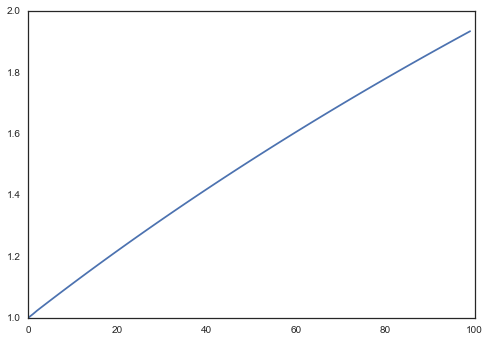

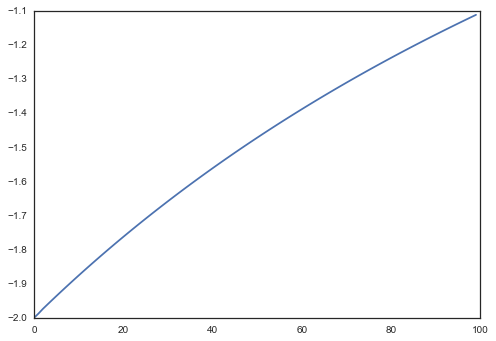

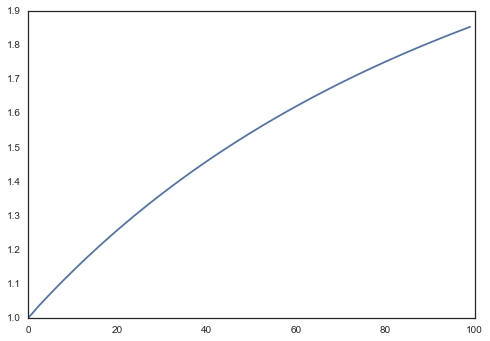

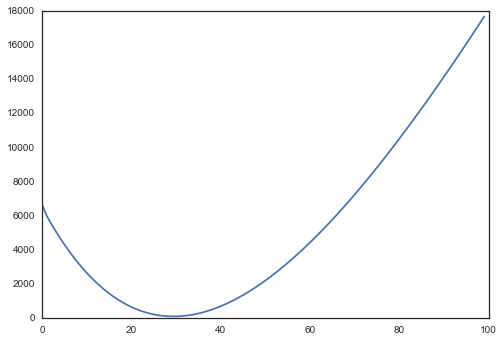

In [217]:
for i in np.arange(0,3):
    plt.figure()
    plt.plot(Atrace[:,i])
plt.figure()
plt.plot(Jnew)


### Interpretation of Plots and Results from Example

The first 3 plots are the traces of A[1], A[2], and A[3] respectively. They are important in that they show that the values of the parameters are changing smoothly.  Previously, when testing the algorithm, choosing a large step size, or a high alpha value would make these plots unstable, giving discontinuous changes in the parameter values. 

The final plot is the trace of "J", or the cost function, over the iterations. Here we conveniently see that there is a local minimum reached at one of the iterations. Therefore, we can take the argmin of J, and that will give us the best coefficients. Also note that the cost function changes smoothly from iteration to iteration, suggesting that our step size and alpha are most likely reasonable.

Given the optimized coefficients, we can see how well the AR model performs when predicting a variety of different trials (shown below).  In the below graphs, the red is the model-predicted movement, while the blue is the original movement.

/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


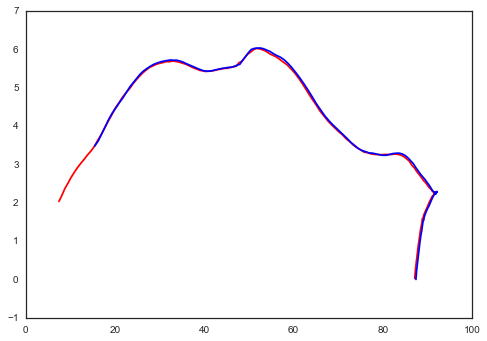

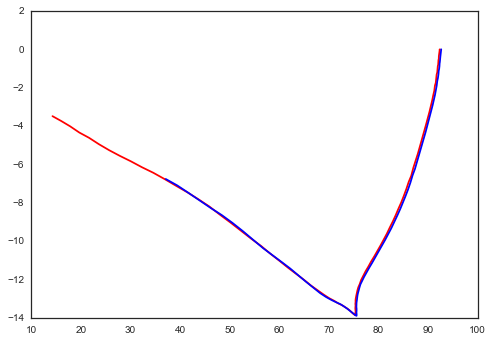

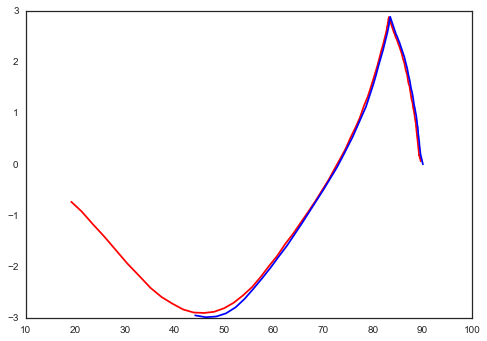

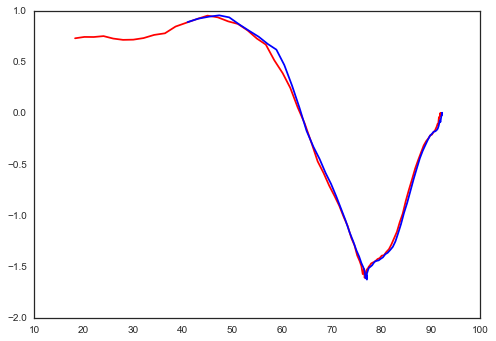

In [228]:
part = 10
for trial in [1,5,10,15]:
    fname = 'Participant_{0}_Trial_{1}.csv'.format(part,trial)
    X = np.genfromtxt(fname, delimiter=',')
    a,s,d,f,g,h,i = ARpredict(X,Abest,0.05,15)
    plt.figure()
    plt.plot(f,g,color='red')
    plt.plot(h,i,color='blue')

### Does the optimization protocol and AR model really work that well?

Turns out, while the graphs look really nice, its not working that well. Thats because the above plots are showing movement in the xy-plane, which means you can't see whether there is any temporal disparity between the predicted positions and the actual positions.

Below, we plot just the x-position or y-position against sampled time for a movement using the optimized coefficients for a 50ms delay, and we see that the prediction is not as spot on as we would hope.

/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


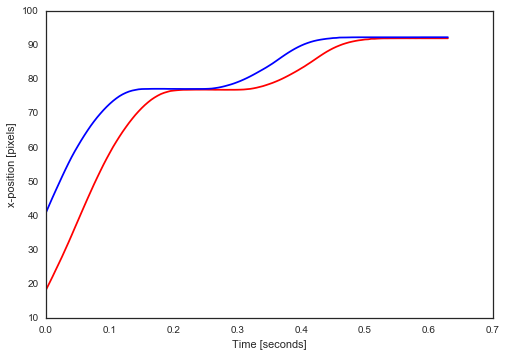

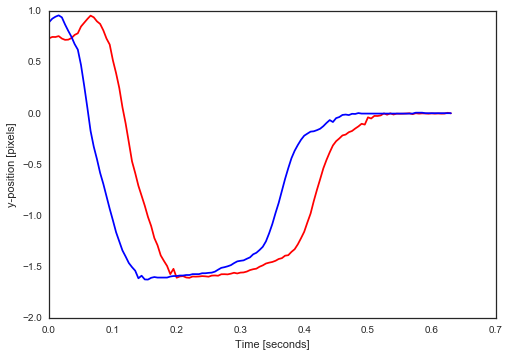

In [231]:
a,s,d,f,g,h,i = ARpredict(X,Abest,0.05,15)
time = (np.arange(0,len(f)))*0.005
plt.figure()
plt.plot(time,f,color='red')
plt.plot(time,h,color='blue')
plt.xlabel('Time [seconds]')
plt.ylabel('x-position [pixels]')
plt.figure()
plt.plot(time,g,color='red')
plt.plot(time,i,color='blue')
plt.xlabel('Time [seconds]')
plt.ylabel('y-position [pixels]')

In [233]:
n = 100
A0 = np.arange(-5,5,0.1)
A1 = np.arange(-5,5,0.1)
A2 = np.arange(-5,5,0.1)
j = np.zeros([len(A0),len(A0),len(A0)])
for a0 in np.arange(0,len(A0)):
    for a1 in np.arange(0,len(A0)):
        for a2 in np.arange(0,len(A0)):
            j[a0,a1,a2] = ARpredict(X,[A0[a0],A1[a1],A2[a2]],0.05,15)[1]


/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/rishisingh/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


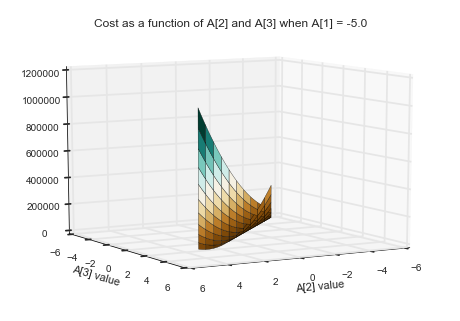

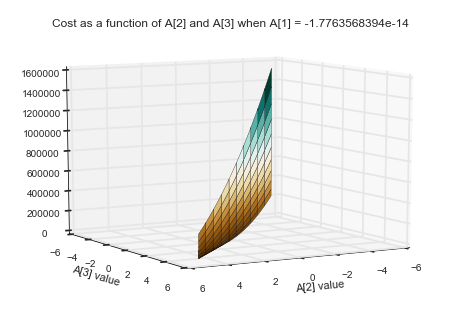

In [240]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
for i in np.arange(0,100,50):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(A1,A2,j[A0[0+i],:,:],cmap='BrBG')
    ax.view_init(elev=10., azim=60)
    plt.show
    f_name = 'Cost as a function of A[2] and A[3] when A[1] = {0}'.format(A0[0+i])
    plt.title(f_name)
    plt.xlabel('A[2] value')
    plt.ylabel('A[3] value')

### Checking the algorithm to see whether it works

To check the algorithm, we created dummy data. The original data is a set of xy-points created by some randomly selected equations that yield all positive values for x and y coordinates. 

Then, another dummy set was created by applying the AR model, with some set coefficients ([1.1,0.5,1]). 

Now, the task of the gradient descent algorithm was simply to find what these coefficients were. At the end, we would expect the gradient descent algorithm to easily find the optimal coefficients to be [1.1,0.5,1].

However, as said earlier, this problem is difficult for the gradient descent algorithm to traverse. This is mainly because changing one parameter can drastically alter the error surface, causing the gradient to change very often.

In [244]:
#creating dummy data for testing
d_points = np.arange(0,10,0.02)
x_dtemp = np.zeros(len(d_points))
y_dtemp = np.zeros(len(d_points))
for i in np.arange(0,len(d_points)):
    dd = d_points[i]
    x_dtemp[i] = -1.0*(dd-2)*(dd-2)+70            # random equation to generate x-points
    y_dtemp[i] = dd*1.00/10.00+np.sqrt(dd*1.00)   # random equation to generate x-points
x_d = np.array(x_dtemp)
y_d = np.array(y_dtemp)

#creating shifted dummy data set
CC = np.array([1.1,0.5,1])                        # use these coefficients to create a convolved dataset
x_dstemp = np.zeros(len(x_d))
y_dstemp = np.zeros(len(y_d))
x_dstemp = np.convolve(x_d,CC)                    # create convolved dataset, the same way the algorithm does above
y_dstemp = np.convolve(y_d,CC) 
x_ds = np.array(x_dstemp[2:-2])
y_ds = np.array(y_dstemp[2:-2])
    
def ARpredict_check(x_d,y_d,x_ds,y_ds,A):         #slightly alter the prediction algorithm to accept the check-data
    xt = np.array(np.convolve(x_d,A))
    yt = np.array(np.convolve(y_d,A))             #here the checking algorithm takes the original data and tries to use some coefficients to convolve it into the other dataset
    x = xt[2:-2]
    y = yt[2:-2]
    diffx = x_ds-x
    diffy = y_ds-y
    SUMerror = np.sum((np.square(diffx)+np.square(diffy)))
    MSerror = np.mean(np.square(diffx)+np.square(diffy)) #MS error (distance^2, pixels^2)
    RMSerror = np.sqrt(np.mean(np.square(diffx)+np.square(diffy)))
    return SUMerror,MSerror,RMSerror,x,y


# altered gradient descent algorithm to take in check data
def grad_descent_check(predict_fun,init_A,input_step,alpha,it):   
    A = init_A                         #initial value of A
    
    Jnew = np.zeros(it)                #cost function, calculates sum total error for all points
    grad = np.zeros([it,len(A)])       #saved differences in cost function when parameters incrementally changed
    A_new = np.zeros(len(A))
    trace = np.zeros([it,len(A)])      #saves all tested A vectors
    delta_J = np.zeros(it)             #changes in cost function for every new set of parameters
    
    Ji = predict_fun(x_d,y_d,x_ds,y_ds,A)[1]  #initial error value
    for k in np.arange(0,it):
        trace[k,:] = A                 #record what the coefficients are for each iteration
        A_test = np.zeros(len(A))
        for i in np.arange(0,len(A)):  #for each coefficient in the AR model calculate gradient
            A_test = A                                #A_test is the incrementally changed coefficient set
            A_test[i] = A_test[i]+input_step          #change individual coefficient at a time
            JJ = predict_fun(x_d,y_d,x_ds,y_ds,A_test)[1]    #calculate new error value
            test = JJ-Ji
            grad[k,i] = JJ-Ji                         #calculate gradient of error w.r.t. changed coefficient
            A_new[i] = A[i]+alpha*grad[k,i]           #use gradient to update new coefficient along path to min     
        Jnew[k] = predict_fun(x_d,y_d,x_ds,y_ds,A_new)[1]    #calculate the latest error value
        delta_J[k] = Jnew[k]-Ji                       #keep track of changes in error
        Ji = Jnew[k]                      #update J value
        A=A_new                        #update A for next iteration
    return A,trace,delta_J,Jnew,grad     

As you can see below, running the prediction algorithm using the predefined coefficients does indeed return the same exact set of xy-points, so the prediction algorithm is working properly

In [119]:
[serror,mserror,rmserror,x,y] = ARpredict_check(x_d,y_d,x_ds,y_ds,CC)

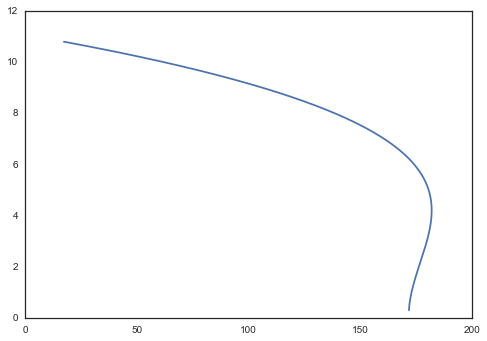

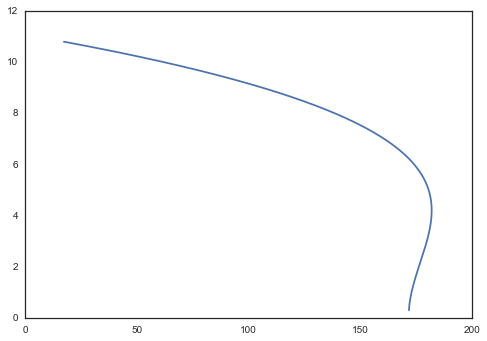

In [113]:
plt.plot(x,y)
plt.figure()
plt.plot(x_ds,y_ds)

## Checking the gradient descent algorithm

In [261]:
A,trace,delta_J,Jnew,grad = grad_descent_check(ARpredict_check,[2,-4,1],0.001,0.00001,10000)
best = np.argmin(Jnew)
Abest = trace[best,:]

print Abest

[ 3.35046573 -2.80871613  2.05640672]


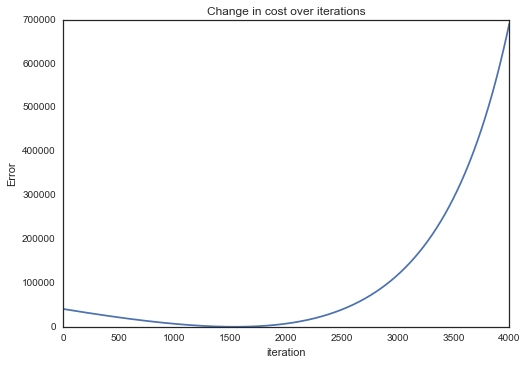

In [265]:
plt.plot(Jnew[0:4000])
plt.ylabel('Error')
plt.xlabel('iteration')
plt.title('Change in cost over iterations')

As you can see above, the gradient descent algorithm is not able to accurately find the optimal coefficients, which should be the coefficients used to generate the data in the first place. This is despite there existing a true local minimum in the error surface (plotted above).

In fact, starting with a slightly different initial condition leads to a completely different set of "best" coefficients.

To make sure this is not an artifact, we have plotted the cost as a function of one of the parameters. We have graphed this cost, as well as the labeled the argmin(cost) for different initial values of the other two parameters. This shows that, given different initial conditions, the optimal value of a coefficient yielding the lowest error can change drastically.

The argmin of the cost is 59
The argmin of the cost is 52
The argmin of the cost is 42
The argmin of the cost is 32
The argmin of the cost is 12


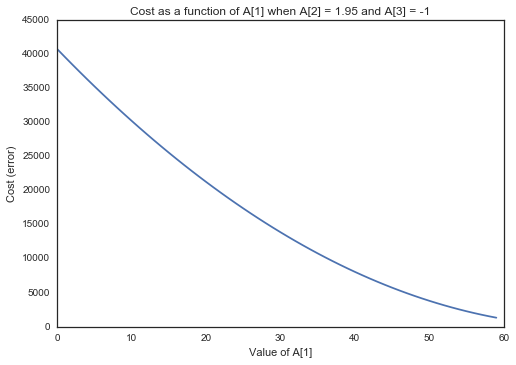

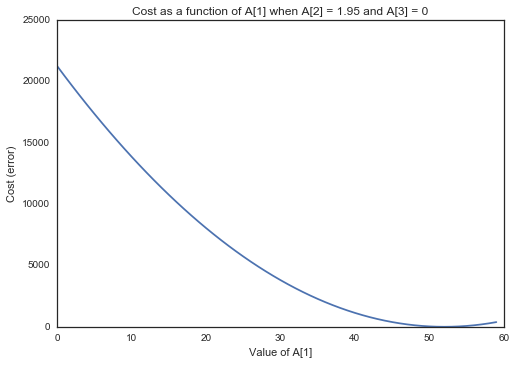

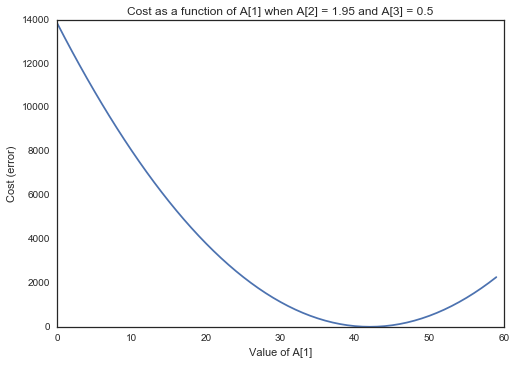

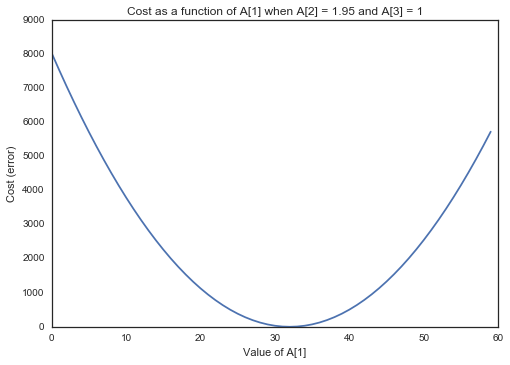

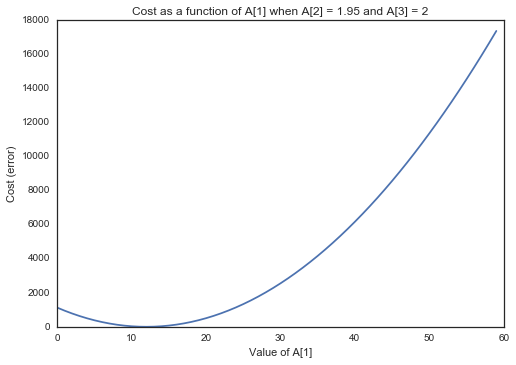

In [268]:
for k in [-1,0,0.5,1,2]:
    J_dummy = np.zeros([len(np.arange(-1,2,0.05)),len(np.arange(0,1,0.05)),len(np.arange(0,2,0.1))])
    Jd = np.arange(-1,2,0.05)
    cnt = 0
    for i in np.arange(-1,2,0.05):
        Jd[cnt] = ARpredict_check(x_d,y_d,x_ds,y_ds,[i*1.00,k,1])[1]
        cnt = cnt+1
    plt.figure()
    plt.plot(Jd)
    plt.ylabel('Cost (error)')
    plt.xlabel('Value of A[1]')
    f_n = 'Cost as a function of A[1] when A[2] = {0} and A[3] = {1}'.format(i,k)
    plt.title(f_n)
    st = 'The argmin of the cost is {0}'.format(np.argmin(Jd))
    plt.show
    print st

# Overall

Overall it seems the use of discrete gradient descent with multiple parameters does not work well with our data or the algorithm we are trying to optimize